##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Better performance with `tf.data`

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/data_performance"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/data_performance.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

GPUs and TPUs can radically reduce the time required to execute a single training step.
Achieving peak performance requires an efficient input pipeline that delivers data for the next step before the current step has finished.
The `tf.data` API helps to build flexible and efficient input pipelines.
This document demonstrates how to use the `tf.data` API's features for building highly performant TensorFlow input pipelines.

Before you continue, you should have read and understood the "[Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)" guide, to know how to use the `tf.data` API.

## Setup

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import time
import timeit
import itertools

from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Resources

* [Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
* `tf.data.Dataset` API

## Optimize performance

To exhibit how performance can be optimized, you will improve a naive example.

First, define a data generator simulating time elapsed to download and read a file from disk.

In [3]:
_datasets_counter = itertools.count()
def get_dataset(num_samples=3):
    """Return a new `tf.data.Dataset`.
    Samples returned by the dataset have a shape of:
        [[None, 1], [None, 2], [None, 3]]
    with types:
        [tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32]
    
    Samples are of the form:
        [(step,),...], [(t0, d), ...], [(d, e, s), ...]]
    where:
        - step is the step name
        - t0 is the timestamp when step started
        - d is the time spent in the step
        - d is the dataset index
        - e is the epoch index (number of times the dataset has been iterated)
        - s is the sample index
    """
    epochs_counters = defaultdict(itertools.count)
    def generator(dataset_idx, num_samples):
        epoch_idx = next(epochs_counters[dataset_idx])
        tf.print("Dataset", dataset_idx, "running epoch #", epoch_idx)
        load_enter = time.perf_counter()
        time.sleep(0.03)  # (Down)loading file in memory
        load_elapsed = time.perf_counter() - load_enter
        for sample_idx in range(num_samples):
            prepare_enter = time.perf_counter()
            time.sleep(0.015)  # Fetching a single "line" from file
            prepare_elapsed = time.perf_counter() - prepare_enter
            if sample_idx <= 0:
                yield (
                    [("load",), ("prepare",)],
                    [(load_enter, load_elapsed), (prepare_enter, prepare_elapsed)],
                    [(dataset_idx, epoch_idx, -1), (dataset_idx, epoch_idx, sample_idx)]
                )
            else:
                yield (
                    [("prepare",)],
                    [(prepare_enter, prepare_elapsed)],
                    [(dataset_idx, epoch_idx, sample_idx)]
                )
            

    return tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32),
        output_shapes=([None, 1], [None, 2], [None, 3]),
        args = (next(_datasets_counter), num_samples)
    )



Then, define a simple "training" loop, simulating the time elapsed to run a single step.

In [51]:
def iterate(ds, num_epochs=tf.constant(2, dtype=tf.dtypes.int64)):
    steps = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values = tf.zeros([0, 3], dtype=tf.dtypes.int32)
    start_time = time.perf_counter()
    for epoch_num in tf.data.Dataset.range(num_epochs):
        epoch_enter = time.perf_counter()
        for (dataset_steps, dataset_times, sample) in ds:
            steps = tf.concat((steps, dataset_steps), axis=0)
            times = tf.concat((times, dataset_times), axis=0)
            values = tf.concat((values, sample), axis=0)
            
            train_enter = time.perf_counter()
            time.sleep(0.01)
            steps = tf.concat((steps, [["train"]]), axis=0)
            times = tf.concat((times, [(train_enter, time.perf_counter() - train_enter)]), axis=0)
            values = tf.concat((values, tf.expand_dims(sample[-1], 0)), axis=0)
            
        steps = tf.concat((steps, [["epoch"]]), axis=0)
        times = tf.concat((times, [(epoch_enter, time.perf_counter() - epoch_enter)]), axis=0)
        values = tf.concat((values, [[-1, epoch_num, -1]]), axis=0)
    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps, "times": times, "values": values}

Define a function to plot a timeline of the pipeline steps.

In [58]:
def draw_timeline(timeline, title="Naive", width=0.5, annotate=True):
    steps = timeline['steps'].numpy()
    times = timeline['times'].numpy()
    values = timeline['values'].numpy()
    metrics = np.unique(steps)

    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)
    
    cmap = mpl.cm.get_cmap("plasma")
    fig, axs = plt.subplots(len(metrics), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, 4.0)
    plt.xlim(-0.01, end)
            
    for i, metric in enumerate(metrics):
        metric_str = metric.decode()
        ax = axs[i]
        ax.set_ylabel(metric_str)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.grid(which="both", axis='x', color="k", linestyle=":")
        
        entries_mask = np.squeeze(steps==metric)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]
        
        ax.broken_barh(serie, (0, 1), color=cmap(i / len(metrics)), alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("d", "e", "s"), annotations[j])])
                ax.text(start + 0.001, 0.5, annotation,
                        horizontalalignment='left', verticalalignment='center')

### The naive approach

Now you are ready to track your performance improvements.

Start by a naive pipeline with no tricks, iterating over your dataset as-is.

Dataset 31 running epoch # 0
Dataset 31 running epoch # 1
Execution time: 0.2837635860014416


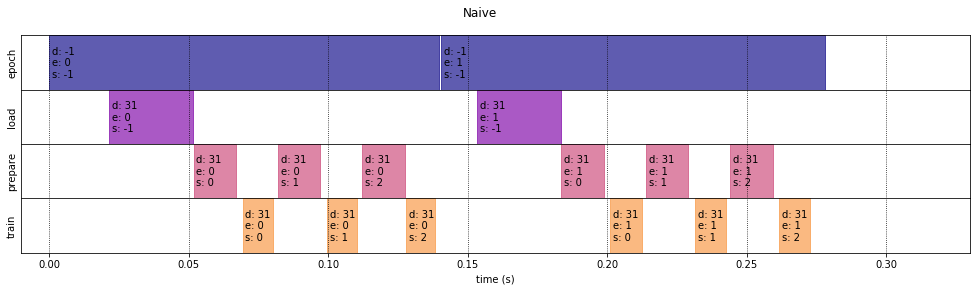

In [59]:
draw_timeline(iterate(get_dataset()), "Naive", 0.33)

The next section builds on this input pipeline, illustrating best practices for designing performant TensorFlow input pipelines.

### Pipelining

To perform a training step, you must first extract and transform the training
data and then feed it to a model running on an accelerator. However, in a naive
synchronous implementation, while the CPU is preparing the data, the accelerator
is sitting idle. Conversely, while the accelerator is training the model, the
CPU is sitting idle. The training step time is thus the sum of both CPU
pre-processing time and the accelerator training time.

**Pipelining** overlaps the preprocessing and model execution of a training
step. While the accelerator is performing training step `N`, the CPU is
preparing the data for step `N+1`. Doing so reduces the step time to the maximum
(as opposed to the sum) of the training and the time it takes to extract and
transform the data.

The `tf.data` API provides a software pipelining mechanism through the
`tf.data.Dataset.prefetch` transformation, which can be used to decouple the
time when data is produced from the time when data is consumed. In particular,
the transformation uses a background thread and an internal buffer to prefetch
elements from the input dataset ahead of the time they are requested. The number
of elements to prefetch should be equal to (or possibly greater than) the number
of batches consumed by a single training step. You could either manually tune
this value, or set it to `tf.data.experimental.AUTOTUNE` which will prompt the
`tf.data` runtime to tune the value dynamically at runtime.

To apply this change to your pipeline, add the `prefetch` call as the last transformation of your input pipeline.

Note that the prefetch transformation provides benefits any time there is an
opportunity to overlap the work of a "producer" with the work of a "consumer."

In [60]:
def get_prefetched_dataset():
    return get_dataset().prefetch(tf.data.experimental.AUTOTUNE)

Dataset 32 running epoch # 0
Dataset 32 running epoch # 1
Execution time: 0.24571881799965922


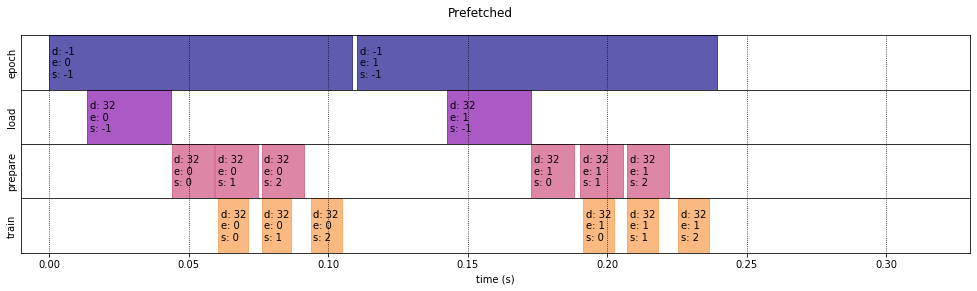

In [61]:
draw_timeline(iterate(get_prefetched_dataset()), "Prefetched", 0.33)

### Parallelize data transformation

When preparing data, input elements may need to be pre-processed. To this
end, the `tf.data` API offers the `tf.data.Dataset.map` transformation, which
applies a user-defined function to each element of the input dataset. Because input elements are
independent of one another, the pre-processing can be parallelized across
multiple CPU cores. To make this possible, the `map` transformation provides the
`num_parallel_calls` argument to specify the level of parallelism.

Choosing the best value for the `num_parallel_calls` argument depends on your
hardware, characteristics of your training data (such as its size and shape),
the cost of your map function, and what other processing is happening on the CPU
at the same time; a simple heuristic is to use the number of available CPU
cores. For instance, if the machine executing the example above had 4 cores, it
would have been more efficient to set `num_parallel_calls=4`. On the other hand,
setting `num_parallel_calls` to a value much greater than the number of
available CPUs can lead to inefficient scheduling, resulting in a slowdown.
Similar to the `prefetch` transformation, the `map` transformation supports
`tf.data.experimental.AUTOTUNE` which will delegate the decision about what
level of parallelism to use to the tf.data runtime.

In [62]:
def mapped_function(s, t, x):
    def _mapped(steps, times, sample):
        map_enter = time.perf_counter()
        time.sleep(0.02)
        map_elapsed = time.perf_counter() - map_enter
        return (
            tf.concat((steps, [["map"]]), axis=0),
            tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
            tf.concat((sample, [sample[-1]]), axis=0)
        )
    return tf.py_function(_mapped, (s, t, x), (s.dtype, t.dtype, x.dtype))

In [63]:
def get_naive_map_dataset():
    return get_dataset().map(mapped_function)

def get_parallel_map_dataset():
    return get_dataset().map(mapped_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Dataset 33 running epoch # 0
Dataset 33 running epoch # 1
Execution time: 0.45368501499979175
Dataset 34 running epoch # 0
Dataset 34 running epoch # 1
Execution time: 0.26074731399967277


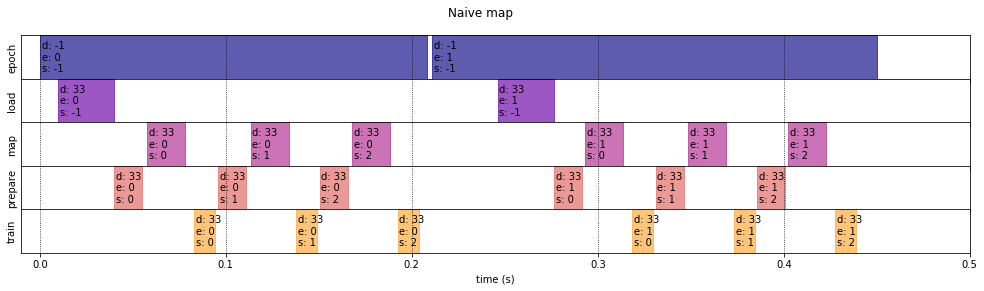

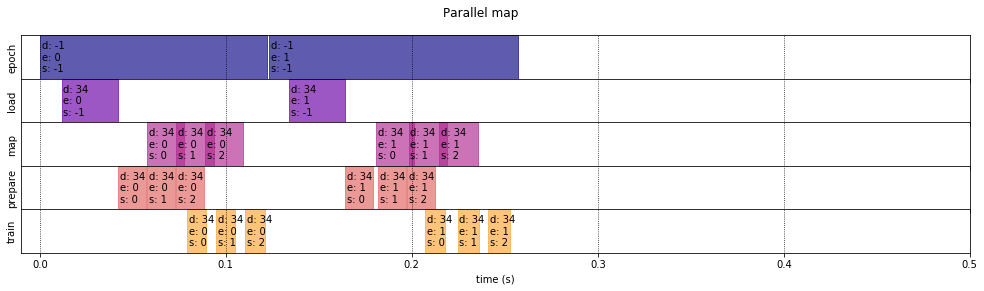

In [64]:
draw_timeline(iterate(get_naive_map_dataset()), "Naive map")
draw_timeline(iterate(get_parallel_map_dataset()), "Parallel map")

### Parallelize data extraction

In a real-world setting, the input data may be stored remotely (for example, GCS
or HDFS), either because the input data would not fit locally or because the
training is distributed and it would not make sense to replicate the input data
on every machine. A dataset pipeline that works well when reading data locally
might become bottlenecked on I/O when reading data remotely because of the
following differences between local and remote storage:

*   **Time-to-first-byte:** Reading the first byte of a file from remote storage
    can take orders of magnitude longer than from local storage.
*   **Read throughput:** While remote storage typically offers large aggregate
    bandwidth, reading a single file might only be able to utilize a small
    fraction of this bandwidth.

In addition, once the raw bytes are read into memory, it may also be necessary
to deserialize and/or decrypt the data (e.g.
[protobuf](https://developers.google.com/protocol-buffers/)), which requires
additional computation. This overhead is present irrespective of whether the
data is stored locally or remotely, but can be worse in the remote case if data
is not prefetched effectively.

To mitigate the impact of the various data extraction overheads, the
`tf.data.Dataset.interleave` transformation can be used to parallelize the data
extraction step, interleaving the contents of other datasets (such as data file
readers). The number of datasets to overlap can be specified by the
`cycle_length` argument, while the level of parallelism can be specified by the
`num_parallel_calls` argument. Similar to the `prefetch` and `map`
transformations, the `interleave` transformation supports
`tf.data.experimental.AUTOTUNE` which will delegate the decision about what
level of parallelism to use to the tf.data runtime.

The following diagram illustrates the effect of supplying `cycle_length=2` and
`num_parallel_calls=2` to the `interleave` transformation:

![parallel io](https://www.tensorflow.org/images/datasets_parallel_io.png)

To apply this change to our running example, replace the call to `TFRecordDataset` by a call to `interleave`.

In [65]:
def get_multifile_map_dataset():
    return tf.data.Dataset.range(2).flat_map(lambda x: get_dataset())

def get_multifile_interleave_dataset():
    return tf.data.Dataset.range(2).interleave(lambda x: get_dataset())

def get_multifile_interleave_parallel_dataset():
    return tf.data.Dataset.range(2).interleave(lambda x: get_dataset(), num_parallel_calls=tf.data.experimental.AUTOTUNE)

Dataset 38 running epoch # 0
Dataset 38 running epoch # 1
Dataset 38 running epoch # 2
Dataset 38 running epoch # 3
Execution time: 0.5497283839995362
Dataset 39 running epoch # 0
Dataset 39 running epoch # 1
Dataset 39 running epoch # 2
Dataset 39 running epoch # 3
Execution time: 0.5633021119992918
Dataset 40 running epoch # 0
Dataset 40 running epoch # 1
Dataset 40 running epoch # 2
Dataset 40 running epoch # 3
Execution time: 0.31967033299952163


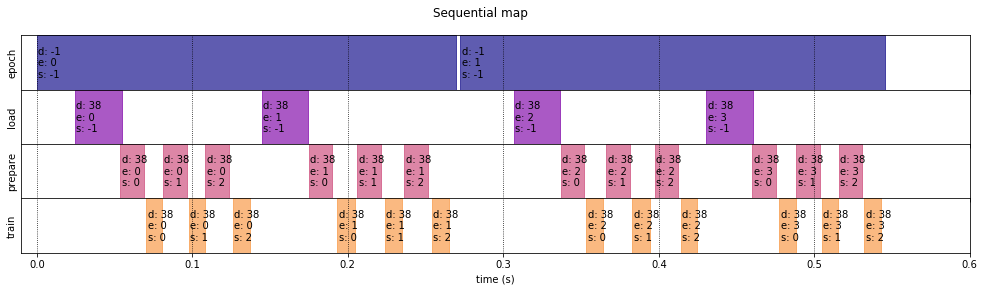

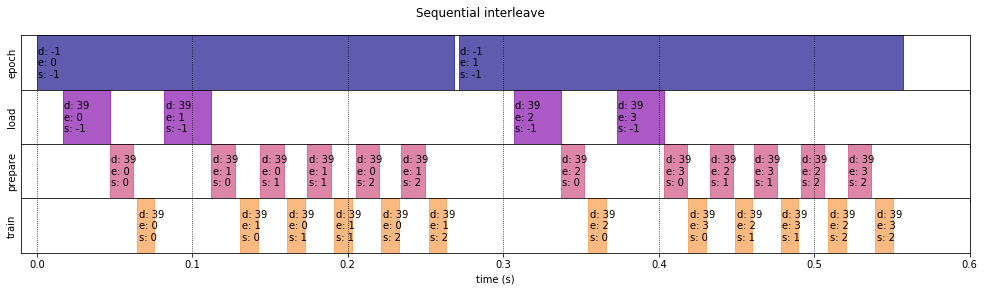

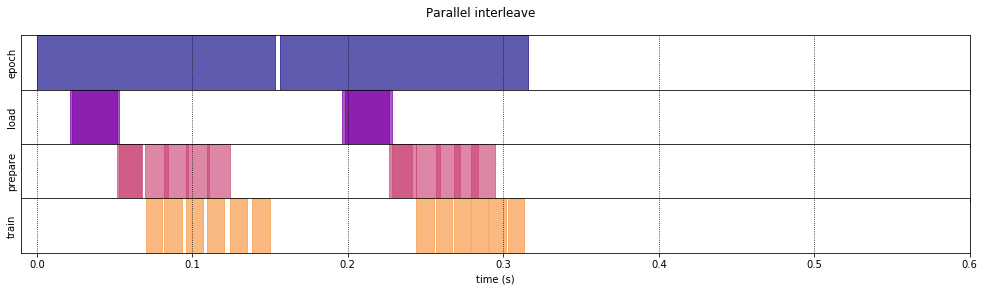

In [67]:
tl1 = iterate(get_multifile_map_dataset())
tl2 = iterate(get_multifile_interleave_dataset())
tl3 = iterate(get_multifile_interleave_parallel_dataset())
draw_timeline(tl1, "Sequential map", 0.6)
draw_timeline(tl2, "Sequential interleave", 0.6)
draw_timeline(tl3, "Parallel interleave", 0.6, annotate=False)

### Caching

The `tf.data.Dataset.cache` transformation can cache a dataset, either in memory or on local storage.
This will prevent some operations (like data loading and preparation) to be executed for each epoch.

In [68]:
def get_cached_dataset():
    return get_dataset().cache()

Dataset 41 running epoch # 0
Execution time: 0.40821071500067774


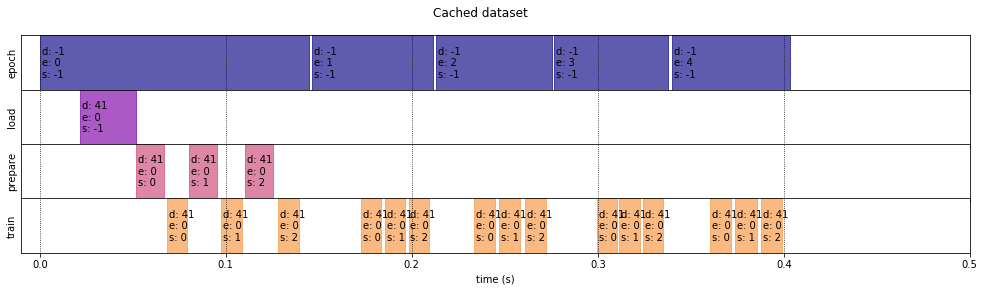

In [69]:
draw_timeline(iterate(get_cached_dataset(), 5), "Cached dataset")

If the user-defined function passed into the `map` transformation is expensive, apply the cache transformation after the `map` transformation as long as the resulting dataset can still fit into memory or local storage.
If the user-defined function increases the space required to store the dataset beyond the cache capacity, consider pre-processing your data before your training job to reduce resource usage.

## Performance considerations

The `tf.data` API is designed around composable transformations to provide its
users with flexibility. Although many of these transformations are commutative,
the ordering of certain transformations has performance implications.

### Map and batch

Invoking the user-defined function passed into the `map` transformation has
overhead related to scheduling and executing the user-defined function.
We recommend vectorizing the user-defined function (that is, have it operate
over a batch of inputs at once) and apply the `batch` transformation _before_
the `map` transformation.

To apply this change to our running example, define a new parsing function,
acting on a batch of serialized examples, and call it after batching our dataset.

In [70]:
_batch_map_num_items = 25

def scalar_mapped_function(s, t, x):
    def _mapped(steps, times, sample):
        map_enter = time.perf_counter()
        time.sleep(0.001)
        map_elapsed = time.perf_counter() - map_enter
        return (
            tf.concat((steps, [["map"]]), axis=0),
            tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
            tf.concat((sample, [sample[-1]]), axis=0)
        )
    return tf.py_function(_mapped, (s, t, x), (s.dtype, t.dtype, x.dtype))

def get_scalar_mapped_dataset():
    return get_dataset(_batch_map_num_items).map(scalar_mapped_function).padded_batch(
        _batch_map_num_items,
        padded_shapes=([3, 1], [3, 2], [3, 3]),
    ).unbatch()

def vectorized_mapped_function(s, t, x):
    def _mapped(steps, times, sample):
        map_enter = time.perf_counter()
        time.sleep(0.001 * sample.shape[0])
        map_elapsed = time.perf_counter() - map_enter
        result = (
            tf.concat((steps, tf.tile([[["map"]]], [sample.shape[0], 1, 1])), axis=1),
            tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [sample.shape[0], 1, 1])), axis=1),
            tf.concat((sample, tf.tile([[sample[:][-1][0]]], [sample.shape[0], 1, 1])), axis=1)
        )
        return result
    return tf.py_function(_mapped, (s, t, x), (s.dtype, t.dtype, x.dtype))

def get_vectorized_mapped_dataset():
    return get_dataset(_batch_map_num_items).padded_batch(
        _batch_map_num_items,
        padded_shapes=([2, 1], [2, 2], [2, 3]),
    ).map(vectorized_mapped_function).unbatch()

Dataset 44 running epoch # 0
Execution time: 0.9372380169988901


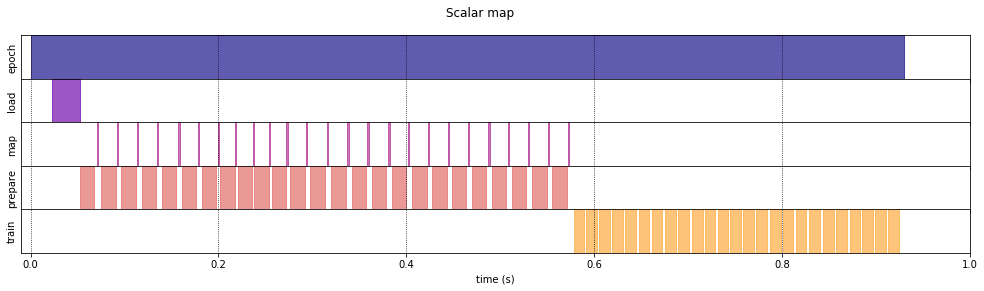

In [73]:
timeline = iterate(get_scalar_mapped_dataset(), 1)
pad_mask = np.logical_or(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
draw_timeline(tf.nest.map_structure(lambda x: x[pad_mask], timeline), "Scalar map", 1, annotate=False)

Dataset 45 running epoch # 0
Execution time: 0.821167569998579


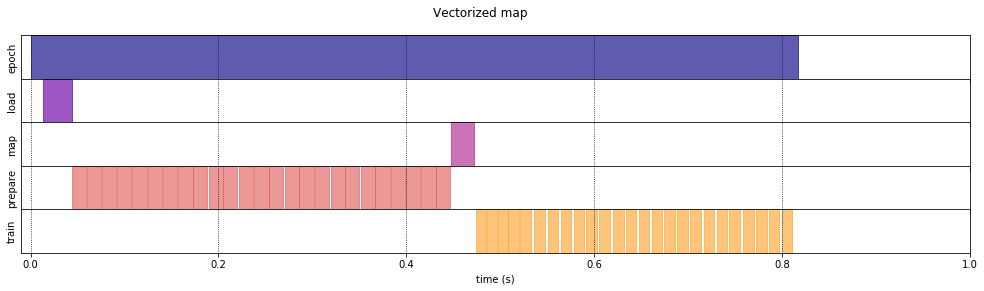

In [74]:
timeline = iterate(get_vectorized_mapped_dataset(), 1)
pad_mask = np.logical_or(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
draw_timeline(tf.nest.map_structure(lambda x: x[pad_mask], timeline), "Vectorized map", 1, annotate=False)

### Map and memory bound operations

A number of transformations, including `interleave`, `prefetch`, and `shuffle`,
maintain an internal buffer of elements. If the user-defined function passed
into the `map` transformation changes the size of the elements, then the
ordering of the map transformation and the transformations that buffer elements
affects the memory usage. In general, we recommend choosing the order that
results in lower memory footprint, unless different ordering is desirable for
performance.

#### Caching partial computations

As seen above, it is recommended to cache you dataset after the `map` transformation except if this transformation make the data too big to fit in memory.
A trade-off can be achieved if your mapped function can be split in two parts: a time consuming one and a memory consuming part.
In this case, you can chain your transformations like below:

```python
dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
```

This way, your time consuming part is only executed during the first epoch, while limiting your memory footprint avoiding big data chunks to be persisted in memory.

## Best practice summary

Here is a summary of the best practices for designing performant TensorFlow
input pipelines:

*   [Use the `prefetch` transformation](#pipelining) to overlap the work of a producer and consumer.
*   [Parallelize the `map` transformation](#parallelize-data-transformation) by setting the `num_parallel_calls` argument.
*   [Parallelize the data reading transformation](#parallelize-data-loading) using the `interleave` transformation.
*   [Vectorize user-defined functions](#map-and-batch) passed in to the `map` transformation
*   [Use the `cache` transformation](#caching) to cache data in memory during the first epoch
*   [Reduce memory usage](#memory-bound-transformations) when applying the `interleave`, `prefetch`, and `shuffle` transformations.